In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.optimize import minimize
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import LinearRegression


In [2]:

# ID du Google Sheet et GID de l'onglet
sheet_id = "1PdnadzZswADLqGBrI53a_8IsegivCMSz1pCZOh384-Y"
gid = "1517184233"

# Construction du lien CSV public de Google Sheets
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

# Lecture du CSV directement dans un DataFrame
df = pd.read_csv(url)

# Si ton tableau commence à la colonne D (donc avec des colonnes vides avant),
# on peut supprimer les colonnes vides automatiquement :
df = df.dropna(axis=1, how="all")
df = df.replace("-", np.nan)
df = df.dropna(subset=["Team Gap Early", "R", "Perf relative", "Perf intrinsèque"])
df['LoseStreak'] = 0
streak = 0
for i, gap in enumerate(df['Team Gap Early']):
    if gap < 0:
        streak += 1
    else:
        streak = 0
    df.at[i, 'LoseStreak'] = streak

In [3]:
df

,% / Rela,% / Intra,Est. Win,Team Gap Early,R,Perf relative,Perf intrinsèque,Unnamed: 9,LoseStreak
0,NaN,NaN,NaN,0.0,1.0,-2.0,0.0,NaN,0
1,NaN,NaN,NaN,-1.0,-1.0,-2.0,0.0,NaN,1
2,NaN,NaN,NaN,2.0,1.0,-1.0,2.0,NaN,0
3,NaN,NaN,NaN,-1.0,1.0,-1.0,0.0,NaN,1
4,NaN,NaN,NaN,-1.0,-1.0,2.0,0.0,- Un mec run down : \nGarder son calme et joue...,2
5,NaN,NaN,NaN,-2.0,-1.0,2.0,1.0,NaN,3
6,NaN,NaN,NaN,1.0,1.0,-2.0,-2.0,NaN,0
7,58,52,55,-2.0,-1.0,2.0,1.0,NaN,1
8,79,67,73,2.0,1.0,-2.0,-1.0,NaN,0
9,48,44,46,-2.0,-1.0,1.0,-2.0,NaN,1


**ATTENTION** : cette formule fait une prédiction entre 20 ET 80 pour le **TEAM GAP EARLY**, pas une prédiction sur la WIN. (on peut le changer)
- Actuellement cette formule est pour la ligne 9 puis il faut la faire glisser sur les autres cases après


In [4]:
# --- Préparer les features ---
features = ["Team Gap Early", "R", "Perf relative", "Perf intrinsèque"]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[features])

window = 7
X, y = [], []
for i in range(len(data_scaled) - window):
    X.append(data_scaled[i:i+window])
    y.append(data_scaled[i + window, 0])  # prédire Team Gap Early

X = np.array(X)
y = np.array(y)

# --- Dataset PyTorch ---
class LoLDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = LoLDataset(X, y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# --- Modèle LSTM simple ---
class LoLModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # dernière sortie
        return out.squeeze(1)

model = LoLModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# --- Entraînement ---
for epoch in range(200):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")

# --- Approximation linéaire pour Excel ---
model.eval()
with torch.no_grad():
    lstm_out, _ = model.lstm(torch.tensor(X, dtype=torch.float32))
    fc_out = model.fc(lstm_out[:, -1, :]).numpy().flatten()  # avant sigmoid

# Flatten X pour régression linéaire
X_flat = X.reshape(X.shape[0], -1)
lin_model = LinearRegression()
lin_model.fit(X_flat, fc_out)


Epoch 0, Loss: 1.0542


Epoch 50, Loss: 0.4495


Epoch 100, Loss: 0.0128


Epoch 150, Loss: 0.0004


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [5]:
def generate_excel_formula_lstm(row, coefs, intercept, window=7):
    features_letters = ["F", "G", "H", "I"]
    terms = [f"{intercept:.6f}".replace(".", ",")]

    for feat_idx, col_letter in enumerate(features_letters):
        lag_terms = []
        for lag_idx in range(window):
            coef_idx = feat_idx * window + lag_idx
            coef = coefs[coef_idx]
            lag_row = row - (window - lag_idx)
            sign = "+" if coef >= 0 else ""
            lag_terms.append(f"{sign}{coef:.6f}*{col_letter}{lag_row}".replace(".", ","))
        terms.append("(" + " + ".join(lag_terms) + ")")

    inner = " + ".join(terms)
    formula = f"=20 + 60 * (1 / (1 + EXP(-({inner}))))"
    return formula

row_number = 31  # dernière ligne avec les 7 lags
formula = generate_excel_formula_lstm(
    row=row_number,
    coefs=lin_model.coef_,
    intercept=lin_model.intercept_,
    window=7
)
print(formula)



=20 + 60 * (1 / (1 + EXP(-(-0,053413 + (+0,387542*F24 + -0,416260*F25 + -0,140499*F26 + -0,161839*F27 + +0,034873*F28 + +0,282217*F29 + +0,260510*F30) + (+0,142056*G24 + -0,081149*G25 + +0,204786*G26 + +0,268832*G27 + -0,316328*G28 + +0,541973*G29 + -0,248327*G30) + (+0,120609*H24 + -0,474139*H25 + -0,393946*H26 + +0,302668*H27 + +0,059403*H28 + +0,348634*H29 + -0,494795*H30) + (+0,350281*I24 + -0,246775*I25 + +0,057571*I26 + -0,337629*I27 + +0,881727*I28 + +0,224558*I29 + -0,401828*I30)))))


### pour la case 31

### Bonus matrice de corrélation

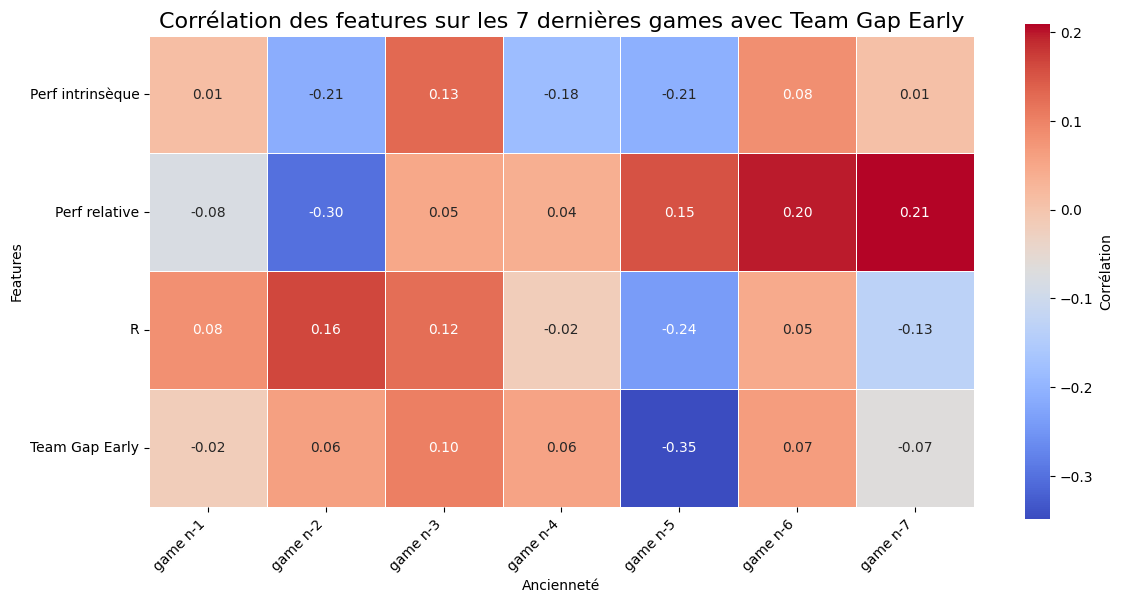

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

features = ['R', 'Perf relative', 'Perf intrinsèque', 'Team Gap Early']
target = 'Team Gap Early'
max_lag = 7

df_lagged = df.copy()

# Créer les colonnes lag
for feat in features:
    for lag in range(1, max_lag + 1):
        df_lagged[f'{feat}_lag{lag}'] = df_lagged[feat].shift(lag)

# Supprimer les lignes avec target NaN
df_corr = df_lagged.dropna(subset=[target])

# Calcul des corrélations
corr_dict = {}
for feat in features:
    for lag in range(1, max_lag + 1):
        corr_dict[f'{feat}_lag{lag}'] = df_corr[target].corr(df_corr[f'{feat}_lag{lag}'])

corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Correlation'])
corr_df['Feature'] = [name.split('_lag')[0] for name in corr_df.index]
corr_df['Lag'] = [int(name.split('_lag')[1]) for name in corr_df.index]

# Pivot pour heatmap
heatmap_data = corr_df.pivot(index='Feature', columns='Lag', values='Correlation')

# Heatmap avec labels
plt.figure(figsize=(12, 6))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Corrélation'},
    linewidths=0.5,
    square=True
)

# Forcer les labels pour toutes les cases
ax.set_xticklabels([f"game n-{i}" for i in heatmap_data.columns], rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(heatmap_data.index, rotation=0, fontsize=10)

plt.title('Corrélation des features sur les 7 dernières games avec Team Gap Early', fontsize=16)
plt.xlabel('Ancienneté')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
